In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time, math
from matplotlib.colors import hsv_to_rgb
from numba import cuda, jit, prange

In [38]:
@cuda.jit
def get_grid_cuda(Z,coef,lenCoef):
    i, j = cuda.grid(2)
    if i >=0 and i < Z.shape[0] and j >=0 and j < Z.shape[1]:     
        for _ in range(500):
            
            fx=0
            for _i in range(lenCoef):
                fx+=coef[_i]*Z[i,j]**(lenCoef-_i-1)

            dfx=0
            for _i in range(lenCoef-1):
                dfx+=coef[_i]*(lenCoef-_i-1)*Z[i,j]**(lenCoef-_i-2)

            
            # fx=Z[i,j]**3+Z[i,j]**2+Z[i,j]+1
            # dfx=3*Z[i,j]**2+2*Z[i,j]+1
            div=fx/dfx
            Z[i,j]=Z[i,j]-div
            if(abs(div)<1e-6):
                break

In [39]:
@jit(nopython=True)
def NewtonR(x):
    for i in range(100):
        fx=x**3+x**2+x+1
        dfx=3*x**2+2*x+1
        div=fx/dfx
        x=x-div
        if(abs(div)<1e-3):
            break
    return x

In [40]:
@jit(nopython=True, parallel=True)
def get_grid(Z):
    for i in prange(len(Z)):
        for j in prange(len(Z[0])):
            Z[i,j]=NewtonR(Z[i,j])
    return Z

C:\Users\joejo\Miniconda3\lib\site-packages\numba\cuda\cudadrv\devicearray.py:790: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Time taken: 7.778867483139038


C:\Users\joejo\Miniconda3\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


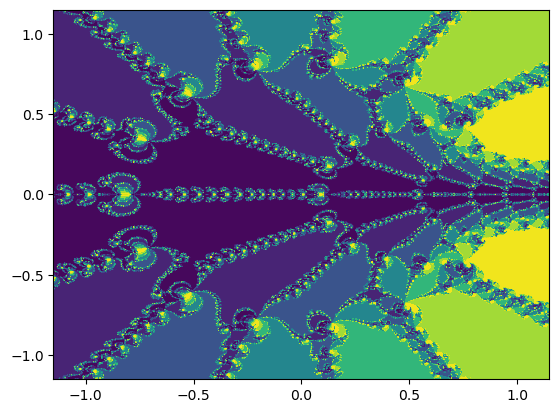

In [41]:
N=2**12
lim=1.15
limj=1.15j

x=np.linspace(-lim,lim,N,dtype=complex)
xj=np.linspace(-limj,limj,N,dtype=complex)
xx,yy=np.meshgrid(x,xj)
X=xx+yy

coef=np.array([1]*15)

Z=np.copy(X)
Z_cpu=np.copy(X)

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(Z.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(Z.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()
get_grid_cuda[blockspergrid, threadsperblock](Z,coef,len(coef))
print("Time taken:",time.time() - start)

# Z_cpu=get_grid(Z_cpu)

plt.contourf(X.real,X.imag,Z,levels=30)
plt.show()
plt.close()

# plt.contourf(X.real,X.imag,Z_cpu,levels=30)
# plt.show()
# plt.close()
